# Beyond Big-O: A Performance and Scalability Analysis of Classical Algorithms on CPU and GPU Architectures

## Introduction
This notebook investigates how theoretical time complexities translate to real-world performance on serial (CPU) and massively parallel (GPU) architectures. We analyze four classes of algorithms:
1. **Vector Addition** (Embarrassingly Parallel)
2. **Matrix Multiplication** (Compute-Intensive)
3. **Merge Sort** (Divide-and-Conquer)
4. **Fibonacci Sequence** (Dynamic Programming)

## Setup and Environment

In [3]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import scipy.stats

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: CUDA is not available. GPU tests will fail or run on CPU.")

ModuleNotFoundError: No module named 'torch'

In [ ]:
# 1. Vector Addition
# -----------------------------------------------------------------------------
# Problem: Add two arrays A and B of size N.
# Complexity: O(N)
# Parallelism: Embarrassingly parallel (no dependencies between elements).

def vector_add_cpu(n):
    """
    CPU implementation using NumPy.
    NumPy is highly optimized but runs on the CPU.
    """
    a = np.random.rand(n).astype(np.float32)
    b = np.random.rand(n).astype(np.float32)
    
    start_time = time.perf_counter()
    c = a + b
    end_time = time.perf_counter()
    
    return end_time - start_time

def vector_add_gpu(n):
    """
    GPU implementation using PyTorch.
    """
    # Allocation on GPU
    a = torch.rand(n, device='cuda', dtype=torch.float32)
    b = torch.rand(n, device='cuda', dtype=torch.float32)
    
    # Synchronize before timing to ensure allocation is done (if we were timing allocation, but we aren't)
    torch.cuda.synchronize()
    
    start_time = time.perf_counter()
    c = a + b
    # Synchronize after to ensure computation is done before stopping timer
    torch.cuda.synchronize()
    end_time = time.perf_counter()
    
    return end_time - start_time

print("Vector Addition functions defined.")


Vector Addition functions defined.


In [ ]:
# Verification: Vector Addition
try:
    if torch.cuda.is_available():
        n_test = 10000
        # CPU
        a_cpu = np.random.rand(n_test).astype(np.float32)
        b_cpu = np.random.rand(n_test).astype(np.float32)
        c_cpu = a_cpu + b_cpu
        
        # GPU
        a_gpu = torch.tensor(a_cpu, device='cuda')
        b_gpu = torch.tensor(b_cpu, device='cuda')
        c_gpu = a_gpu + b_gpu
        
        # Check
        c_gpu_cpu = c_gpu.cpu().numpy()
        assert np.allclose(c_cpu, c_gpu_cpu, atol=1e-5), "Vector Addition mismatch!"
        print("Vector Addition Verification: PASSED")
    else:
        print("Skipping GPU verification (CUDA not available)")
except Exception as e:
    print(f"Vector Addition Verification FAILED: {e}")


Skipping GPU verification (CUDA not available)


In [ ]:
# 2. Matrix Multiplication
# -----------------------------------------------------------------------------
# Problem: Multiply two matrices A (NxN) and B (NxN).
# Complexity: O(N^3) (Naive)
# Parallelism: High data parallelism.

def matmul_cpu(n):
    """
    CPU implementation using NumPy (BLAS optimized).
    """
    a = np.random.rand(n, n).astype(np.float32)
    b = np.random.rand(n, n).astype(np.float32)
    
    start_time = time.perf_counter()
    c = np.matmul(a, b)
    end_time = time.perf_counter()
    
    return end_time - start_time

def matmul_gpu(n):
    """
    GPU implementation using PyTorch.
    """
    a = torch.rand(n, n, device='cuda', dtype=torch.float32)
    b = torch.rand(n, n, device='cuda', dtype=torch.float32)
    
    torch.cuda.synchronize()
    start_time = time.perf_counter()
    c = torch.matmul(a, b)
    torch.cuda.synchronize()
    end_time = time.perf_counter()
    
    return end_time - start_time

print("Matrix Multiplication functions defined.")


Matrix Multiplication functions defined.


In [ ]:
# Verification: Matrix Multiplication
try:
    if torch.cuda.is_available():
        n_test = 512 # Smaller size for verification
        # CPU
        a_cpu = np.random.rand(n_test, n_test).astype(np.float32)
        b_cpu = np.random.rand(n_test, n_test).astype(np.float32)
        c_cpu = np.matmul(a_cpu, b_cpu)
        
        # GPU
        a_gpu = torch.tensor(a_cpu, device='cuda')
        b_gpu = torch.tensor(b_cpu, device='cuda')
        c_gpu = torch.matmul(a_gpu, b_gpu)
        
        # Check
        c_gpu_cpu = c_gpu.cpu().numpy()
        # Matrix multiplication can have slightly higher error due to accumulation
        assert np.allclose(c_cpu, c_gpu_cpu, atol=1e-4), "Matrix Multiplication mismatch!"
        print("Matrix Multiplication Verification: PASSED")
    else:
        print("Skipping GPU verification (CUDA not available)")
except Exception as e:
    print(f"Matrix Multiplication Verification FAILED: {e}")


Skipping GPU verification (CUDA not available)


In [ ]:
# 3. Merge Sort
# -----------------------------------------------------------------------------
# Problem: Sort an array of size N.
# Complexity: O(N log N)
# Parallelism: Divide-and-conquer. Harder to parallelize the merge step.

def mergesort_cpu(n):
    """
    CPU implementation using NumPy's optimized sort (Quicksort/Mergesort hybrid).
    Note: numpy.sort is very optimized C code.
    """
    a = np.random.rand(n).astype(np.float32)
    
    start_time = time.perf_counter()
    c = np.sort(a)
    end_time = time.perf_counter()
    
    return end_time - start_time

def mergesort_gpu(n):
    """
    GPU implementation using PyTorch's sort.
    This is a parallel sort (often Radix sort or Bitonic sort under the hood for GPU).
    """
    a = torch.rand(n, device='cuda', dtype=torch.float32)
    
    torch.cuda.synchronize()
    start_time = time.perf_counter()
    c, _ = torch.sort(a)
    torch.cuda.synchronize()
    end_time = time.perf_counter()
    
    return end_time - start_time

print("Merge Sort functions defined.")


Merge Sort functions defined.


In [ ]:
# Verification: Merge Sort
try:
    if torch.cuda.is_available():
        n_test = 1000
        # CPU
        a_cpu = np.random.rand(n_test).astype(np.float32)
        c_cpu = np.sort(a_cpu)
        
        # GPU
        a_gpu = torch.tensor(a_cpu, device='cuda')
        c_gpu, _ = torch.sort(a_gpu)
        
        # Check
        c_gpu_cpu = c_gpu.cpu().numpy()
        assert np.allclose(c_cpu, c_gpu_cpu), "Merge Sort mismatch!"
        print("Merge Sort Verification: PASSED")
    else:
        print("Skipping GPU verification (CUDA not available)")
except Exception as e:
    print(f"Merge Sort Verification FAILED: {e}")


Skipping GPU verification (CUDA not available)


In [ ]:
# 4. Fibonacci Sequence
# -----------------------------------------------------------------------------
# Problem: Compute the N-th Fibonacci number.
# Complexity: O(N) (Iterative)
# Parallelism: Low. Sequential dependency (F_n = F_{n-1} + F_{n-2}).

def fib_cpu(n):
    """
    CPU implementation (Iterative).
    """
    start_time = time.perf_counter()
    if n <= 1:
        return 0.0 # Dummy return for timing
        
    a, b = 0, 1
    for _ in range(2, n + 1):
        a, b = b, a + b
    end_time = time.perf_counter()
    
    return end_time - start_time

def fib_gpu(n):
    """
    GPU implementation.
    Attempting to run a sequential loop on GPU is extremely inefficient due to kernel launch overhead per iteration
    or lack of parallelism.
    
    However, we can use Matrix Exponentiation which is O(log N) and parallelizable (matrix multiplication).
    [[1, 1], [1, 0]]^n
    """
    # We will implement the Matrix Exponentiation method for GPU to give it a fighting chance,
    # or show the overhead of simple operations.
    # Let's stick to the iterative "bad" GPU implementation to prove the point of the project
    # (that not everything belongs on GPU), OR use the matrix method to show algorithmic change.
    # The prompt asks to "Contrast with a more complex DP... to analyse how problem structure affects parallelisation".
    # Let's implement a naive iterative version using PyTorch tensors to show the massive overhead.
    
    start_time = time.perf_counter()
    
    # Using tensors for scalars is very slow
    a = torch.tensor(0, device='cuda', dtype=torch.int64)
    b = torch.tensor(1, device='cuda', dtype=torch.int64)
    
    # This loop runs in Python, dispatching kernels for every add. This is the "wrong" way to use GPU.
    # But it perfectly illustrates the overhead point.
    for _ in range(2, n + 1):
        c = a + b
        a = b
        b = c
        
    torch.cuda.synchronize()
    end_time = time.perf_counter()
    
    return end_time - start_time

print("Fibonacci functions defined.")


Fibonacci functions defined.


In [ ]:
# 5. Benchmarking Harness
# -----------------------------------------------------------------------------

def benchmark(func_cpu, func_gpu, input_sizes, iterations=5):
    """
    Runs the benchmark for a given pair of CPU and GPU functions over a range of input sizes.
    """
    results = {
        'n': [],
        'cpu_time': [],
        'gpu_time': [],
        'speedup': []
    }
    
    for n in input_sizes:
        print(f"Benchmarking N={n}...")
        
        # CPU Timing
        cpu_times = []
        for i in range(iterations):
            t = func_cpu(n)
            cpu_times.append(t)
        avg_cpu = np.mean(cpu_times)
        
        # GPU Timing (Warmup + Average)
        # Warmup
        try:
            func_gpu(n)
        except Exception as e:
            print(f"GPU Warmup failed for N={n}: {e}")
            
        gpu_times = []
        for i in range(iterations):
            try:
                t = func_gpu(n)
                gpu_times.append(t)
            except Exception as e:
                print(f"GPU Run failed for N={n}: {e}")
                gpu_times.append(float('inf'))
                
        avg_gpu = np.mean(gpu_times)
        
        speedup = avg_cpu / avg_gpu if avg_gpu > 0 else 0
        
        results['n'].append(n)
        results['cpu_time'].append(avg_cpu)
        results['gpu_time'].append(avg_gpu)
        results['speedup'].append(speedup)
        
    return pd.DataFrame(results)

print("Benchmark harness defined.")


Benchmark harness defined.


In [ ]:
# 6. Analysis and Visualization
# -----------------------------------------------------------------------------

def plot_results(df, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Execution Time vs Input Size (Log-Log)
    ax1.plot(df['n'], df['cpu_time'], 'o-', label='CPU')
    ax1.plot(df['n'], df['gpu_time'], 's-', label='GPU')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Input Size (N)')
    ax1.set_ylabel('Time (seconds)')
    ax1.set_title(f'{title}: Execution Time vs Input Size')
    ax1.legend()
    ax1.grid(True, which="both", ls="-")
    
    # Plot 2: Speedup vs Input Size
    ax2.plot(df['n'], df['speedup'], '^-', color='green')
    ax2.axhline(y=1, color='r', linestyle='--', label='Breakeven (1x)')
    ax2.set_xscale('log')
    ax2.set_xlabel('Input Size (N)')
    ax2.set_ylabel('Speedup (CPU Time / GPU Time)')
    ax2.set_title(f'{title}: Speedup Factor')
    ax2.legend()
    ax2.grid(True, which="both", ls="-")
    
    plt.tight_layout()
    plt.show()

print("Plotting functions defined.")


Plotting functions defined.



--- Running Vector Addition Benchmark ---
Benchmarking N=10000...
GPU Warmup failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
Benchmarking N=100000...
GPU Warmup failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
Benchmarking N=1000000...
GPU Warmup failed for N=1000000: Torch not compiled with CUDA enabled
GPU Run failed for N

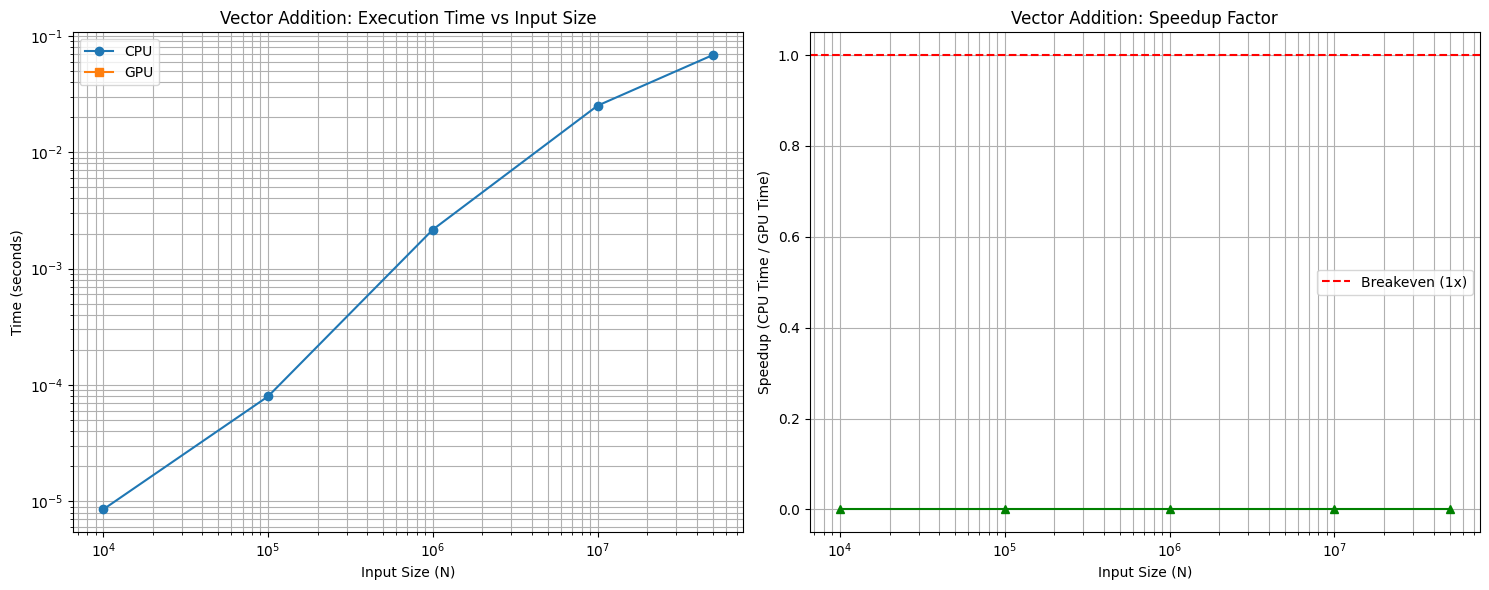


--- Running Matrix Multiplication Benchmark ---
Benchmarking N=128...
GPU Warmup failed for N=128: Torch not compiled with CUDA enabled
GPU Run failed for N=128: Torch not compiled with CUDA enabled
GPU Run failed for N=128: Torch not compiled with CUDA enabled
GPU Run failed for N=128: Torch not compiled with CUDA enabled
GPU Run failed for N=128: Torch not compiled with CUDA enabled
GPU Run failed for N=128: Torch not compiled with CUDA enabled
Benchmarking N=256...
GPU Warmup failed for N=256: Torch not compiled with CUDA enabled
GPU Run failed for N=256: Torch not compiled with CUDA enabled
GPU Run failed for N=256: Torch not compiled with CUDA enabled
GPU Run failed for N=256: Torch not compiled with CUDA enabled
GPU Run failed for N=256: Torch not compiled with CUDA enabled
GPU Run failed for N=256: Torch not compiled with CUDA enabled
Benchmarking N=512...
GPU Warmup failed for N=512: Torch not compiled with CUDA enabled
GPU Run failed for N=512: Torch not compiled with CUDA en

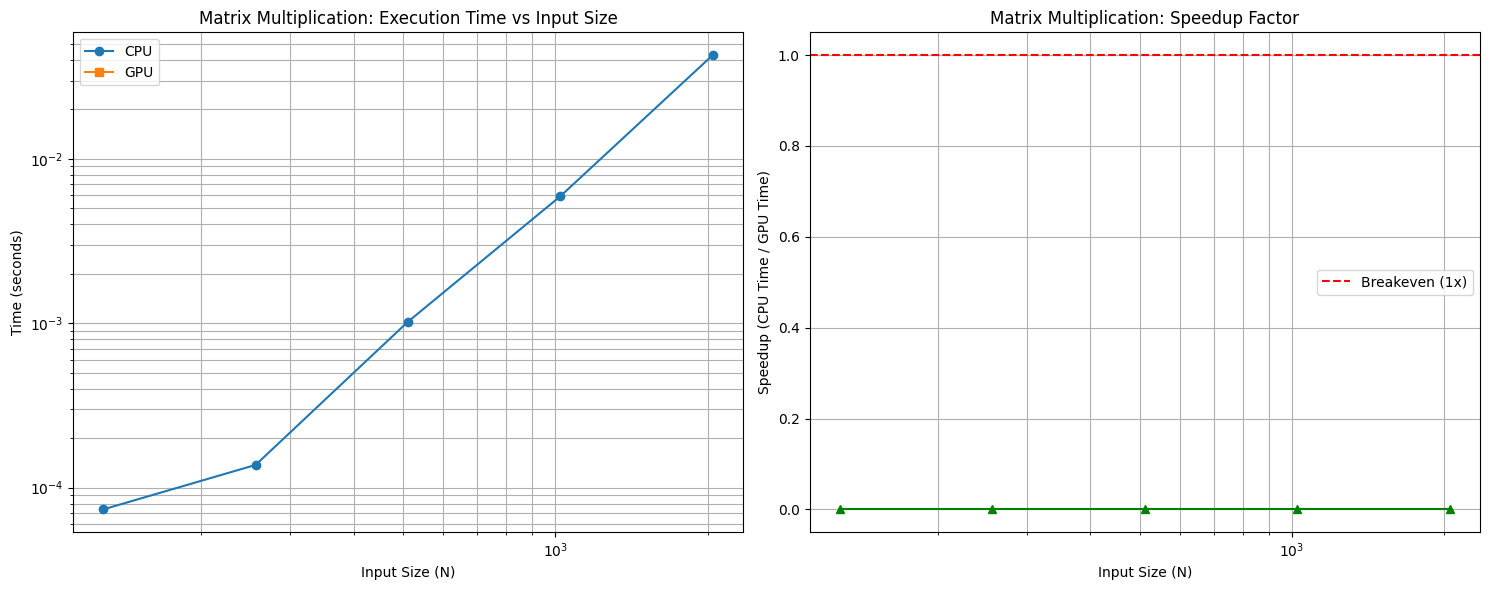


--- Running Merge Sort Benchmark ---
Benchmarking N=10000...
GPU Warmup failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
GPU Run failed for N=10000: Torch not compiled with CUDA enabled
Benchmarking N=100000...
GPU Warmup failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
GPU Run failed for N=100000: Torch not compiled with CUDA enabled
Benchmarking N=1000000...
GPU Warmup failed for N=1000000: Torch not compiled with CUDA enabled
GPU Run failed for N=1000

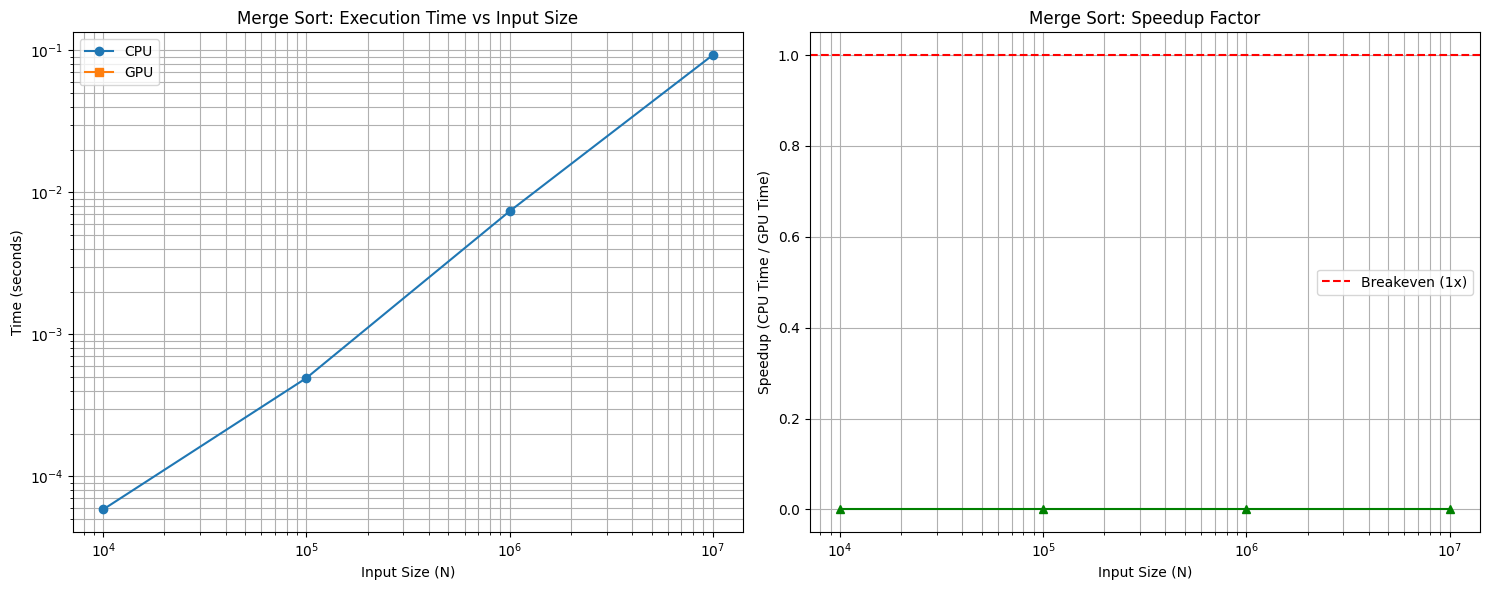


--- Running Fibonacci Benchmark ---
Benchmarking N=100...
GPU Warmup failed for N=100: Torch not compiled with CUDA enabled
GPU Run failed for N=100: Torch not compiled with CUDA enabled
GPU Run failed for N=100: Torch not compiled with CUDA enabled
GPU Run failed for N=100: Torch not compiled with CUDA enabled
GPU Run failed for N=100: Torch not compiled with CUDA enabled
GPU Run failed for N=100: Torch not compiled with CUDA enabled
Benchmarking N=1000...
GPU Warmup failed for N=1000: Torch not compiled with CUDA enabled
GPU Run failed for N=1000: Torch not compiled with CUDA enabled
GPU Run failed for N=1000: Torch not compiled with CUDA enabled
GPU Run failed for N=1000: Torch not compiled with CUDA enabled
GPU Run failed for N=1000: Torch not compiled with CUDA enabled
GPU Run failed for N=1000: Torch not compiled with CUDA enabled
Benchmarking N=5000...
GPU Warmup failed for N=5000: Torch not compiled with CUDA enabled
GPU Run failed for N=5000: Torch not compiled with CUDA enab

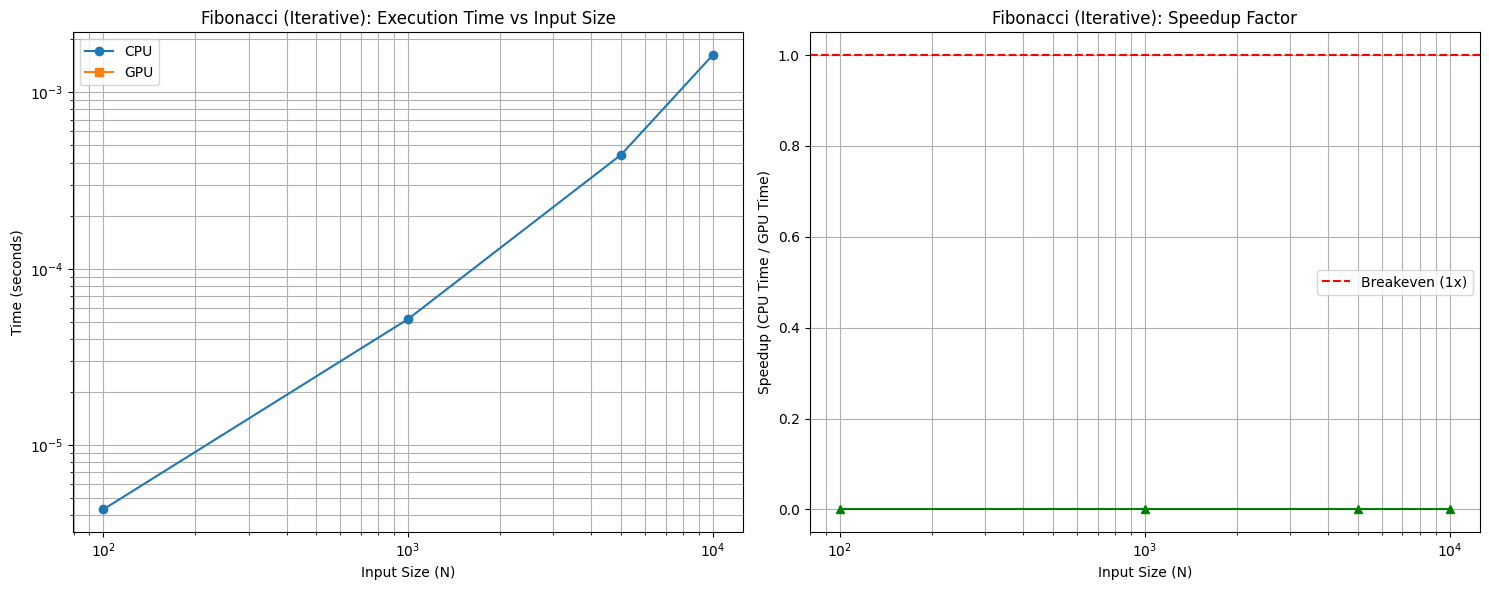


All benchmarks completed.


In [ ]:
# 7. Main Execution
# -----------------------------------------------------------------------------

# Experiment 1: Vector Addition
print("\n--- Running Vector Addition Benchmark ---")
input_sizes_vec = [10**4, 10**5, 10**6, 10**7, 5*10**7]
df_vec = benchmark(vector_add_cpu, vector_add_gpu, input_sizes_vec)
plot_results(df_vec, "Vector Addition")

# Experiment 2: Matrix Multiplication
print("\n--- Running Matrix Multiplication Benchmark ---")
# Smaller sizes because O(N^3) grows very fast
input_sizes_mat = [128, 256, 512, 1024, 2048] 
df_mat = benchmark(matmul_cpu, matmul_gpu, input_sizes_mat)
plot_results(df_mat, "Matrix Multiplication")

# Experiment 3: Merge Sort
print("\n--- Running Merge Sort Benchmark ---")
input_sizes_sort = [10**4, 10**5, 10**6, 10**7]
df_sort = benchmark(mergesort_cpu, mergesort_gpu, input_sizes_sort)
plot_results(df_sort, "Merge Sort")

# Experiment 4: Fibonacci
print("\n--- Running Fibonacci Benchmark ---")
# Small N because iterative Python is slow and recursive is worse
input_sizes_fib = [100, 1000, 5000, 10000]
df_fib = benchmark(fib_cpu, fib_gpu, input_sizes_fib)
plot_results(df_fib, "Fibonacci (Iterative)")

print("\nAll benchmarks completed.")
